<a href="https://colab.research.google.com/github/2018007956/HYU/blob/main/Bioinformatics/graph_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Nov 23 05:34:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Environment
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install pytorch-lightning
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 44.3 MB/s 
     |████████████████████████████████| 2.4 MB 46.8 MB/s 
     |████████████████████████████████| 709 kB 11.0 MB/s 
     |████████████████████████████████| 467 kB 5.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=02d60885d70fd36a8240178d70985e1ea2085b3d277c521efec33680dbdfe913
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public

In [ ]:
# Dataset
from torch_geometric.datasets import ZINC
# for ZINC
# x contains atom type
# edge_attr contains bond type

training_dataset = ZINC(root='./ZINC_dataset', subset=True, split='train')
validation_dataset = ZINC(root='./ZINC_dataset', subset=True, split='val')

print(training_dataset)
print(validation_dataset)
print(training_dataset[0])
print(validation_dataset[0])

# GÓMEZ-BOMBARELLI, Rafael, et al. Automatic chemical design using a data-driven continuous representation of molecules. ACS central science, 2018, 4.2: 268-276.
# https://www.kaggle.com/datasets/basu369victor/zinc250k

Extracting ZINC_dataset/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 11724.42it/s]

ZINC(10000)
ZINC(1000)
Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])
Data(x=[35, 1], edge_index=[2, 78], edge_attr=[78], y=[1])



Done!


In [ ]:
# Pytorch-lightning datamodule
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

from torch_geometric.data import Batch
from torch.nn.functional import pad, one_hot
from torch import argmax

class CustomData(LightningDataModule):
  def __init__(self, training_set, validation_set=None, test_set=None, batch_size=128, num_workers=1):
    super().__init__()
    self.training_set = training_set
    self.validation_set = validation_set
    self.test_set = test_set
    self.batch_size = batch_size
    self.num_workers = num_workers
  
  def func1(self, batch):
    for data in batch:
      data.x = one_hot(data.x.view(-1,), num_classes=64)
      data.edge_attr = one_hot(data.edge_attr, num_classes=4)
      data.x = data.x.type('torch.FloatTensor')
      data.edge_attr = data.edge_attr.type('torch.FloatTensor')
      data.y = data.y.type('torch.FloatTensor')
    return Batch.from_data_list(batch)

  def func2(self, batch):
    for data in batch:
      data.x = argmax(data.x, dim=1, keepdim=True)
      data.x = one_hot(data.x.view(-1,), num_classes=64)
      data.edge_attr = argmax(data.edge_attr, dim=1)
      data.edge_attr = one_hot(data.edge_attr, num_classes=4)
      data.x = data.x.type('torch.FloatTensor')
      data.edge_attr = data.edge_attr.type('torch.FloatTensor')
      data.y = data.y.type('torch.FloatTensor')
    return Batch.from_data_list(batch)

  def collate_function(self, batch):
    if batch[0].x.size()[1] == 1:
      return self.func1(batch)
    else:
      return self.func2(batch)
    
  def train_dataloader(self):
    if self.training_set is not None:
      return DataLoader(self.training_set, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, collate_fn=self.collate_function)
    else:
      print('The training dataset is empty')
      exit()

  def val_dataloader(self):
    if self.validation_set is not None:
      return DataLoader(self.validation_set, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate_function)
    else:
      print('The validation dataset is empty')
  
  def test_dataloader(self):
    if self.test_set is not None:
      return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate_function)
    else:
      print('The test dataset is empty')

In [ ]:
# check the custom datamodule
data_module = CustomData(training_dataset, validation_dataset)
for a in data_module.train_dataloader():
  print(a.x.size())
  print(a.edge_attr.size())
  print(a.edge_index.size())
  print(a.batch.size())
  break

torch.Size([3072, 64])
torch.Size([6634, 4])
torch.Size([2, 6634])
torch.Size([3072])


In [ ]:
# Pytorch and pytorch-geomtric module
from torch.nn import Module
from torch_geometric.nn import GCNConv

class CustomEncoder(Module):
  def __init__(self, input_size, layer_size=64):
    super().__init__()
    self.input_size = input_size
    self.layer_size = layer_size
    self.setup()

  def setup(self):
    self.first_layer = GCNConv(self.input_size, self.layer_size)
    self.last_layer = GCNConv(self.layer_size, self.layer_size)

  def forward(self, batch):
    z = self.first_layer(batch.x, batch.edge_index)
    z = self.last_layer(z, batch.edge_index)
    return z

In [ ]:
# Variational graph auto encoder
from torch_geometric.nn import GAE

gae = GAE(CustomEncoder(64))
print(gae) # GAE안에 loss 계산이 들어있음

GAE(
  (encoder): CustomEncoder(
    (first_layer): GCNConv(64, 64)
    (last_layer): GCNConv(64, 64)
  )
  (decoder): InnerProductDecoder()
)


In [ ]:
# Pytorch-lightning module
from pytorch_lightning import LightningModule
from torch.optim import Adam
from torch_geometric.nn import global_mean_pool # 분자:그래프,원자:노드 -> 하나의 그래프에 대한 벡터를 만들어 주려고 여러 노드의 평균값을 계산
import torch

class CustomModel(LightningModule):
  def __init__(self, model, learning_rate=1e-3):
    super().__init__()
    self.model = model
    self.lr = learning_rate

  def forward(self, batch, mode):
    z = self.model.encode(batch)
    loss = self.model.recon_loss(z, batch.edge_index)
    self.log(f"{mode}_loss", loss, batch_size=batch.y.size(0), prog_bar=True, on_step=False, on_epoch=True)
    return loss, z, batch.y
  
  def training_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'train')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def validation_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'val')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def predict_step(self, batch, batch_idx):
    z = self.model.encode(batch) # 어떤 벡터인지를 찾고
    graph = global_mean_pool(z, batch.batch) # 그 벡터를 GLOBAL MEAN POOL-> 그래프에 대한 값으로 바꿔서 하나의 값이 될 수있도록 바꿔줌
    return graph
  # 임베딩된 정보를 다른 데이터셋에서 가져가서 사용하고 싶어서

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.lr)
    return optimizer

In [ ]:
# Model
model = CustomModel(gae)
print(model)

CustomModel(
  (model): GAE(
    (encoder): CustomEncoder(
      (first_layer): GCNConv(64, 64)
      (last_layer): GCNConv(64, 64)
    )
    (decoder): InnerProductDecoder()
  )
)


In [ ]:
# Training and save model
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')

checkpoint = ModelCheckpoint(dirpath='./model', filename='zinc_model', monitor='val_loss', mode='min')

# trainer = Trainer(max_epochs=3, accelerator='gpu', devices=[0], callbacks=[checkpoint])
trainer = Trainer(max_epochs=1, accelerator='cpu', callbacks=[checkpoint])

trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | GAE  | 8.3 K 
-------------------------------
8.3 K     Trainable params
0         Non-trainable params
8.3 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# Predict
predicted_train = trainer.predict(model, dataloaders=data_module.train_dataloader())
predicted_train = torch.concat(predicted_train, axis=0)
print(len(predicted_train))

Predicting: 79it [00:00, ?it/s]

10000


In [ ]:
# Dimension reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out = pca.fit_transform(predicted_train)
print(pca.explained_variance_ratio_)
zinc_2d = [out[:,idx] for idx in range(2)]

[0.42779549 0.26651453]


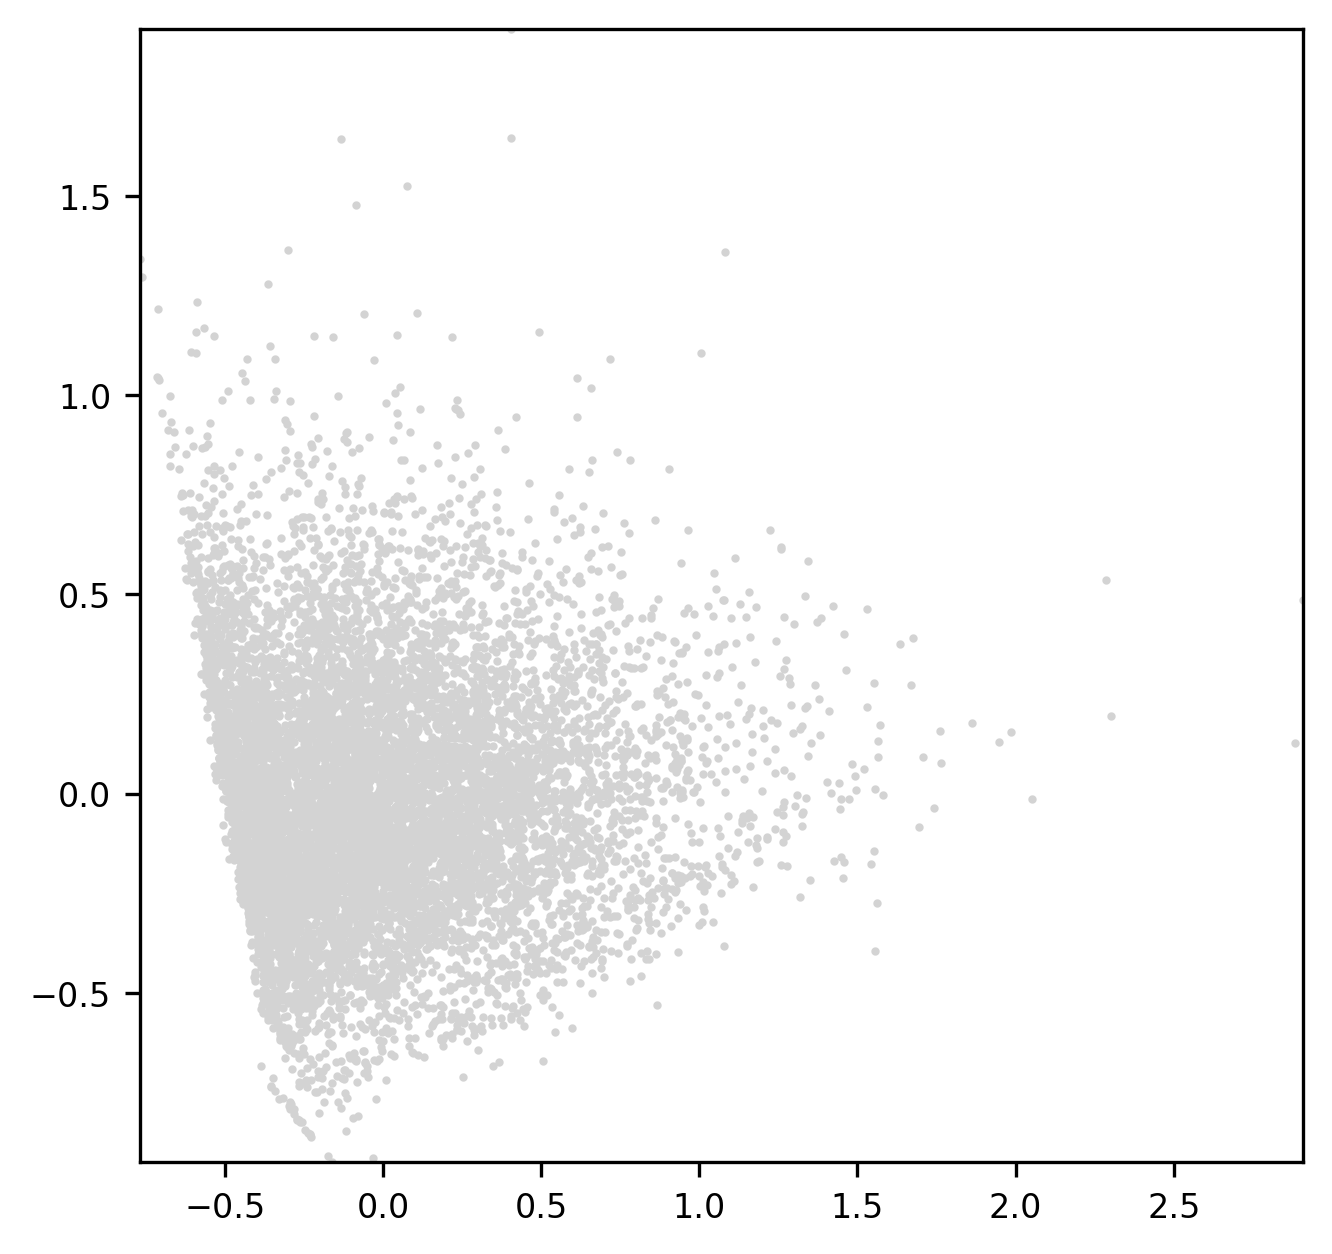

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5), dpi=300) #dpi:해상도
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.set_xlim(zinc_2d[0].min(), zinc_2d[0].max())
ax.set_ylim(zinc_2d[1].min(), zinc_2d[1].max())
marker_size = 4

x = zinc_2d[0]
y = zinc_2d[1]

ax.scatter(x, y, c='lightgrey', s=marker_size, marker=".")